<a href="https://colab.research.google.com/github/iofabela/tf_clothes_sorter/blob/main/tf_clothes_sorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds 

In [ ]:
data, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCYHIJ7/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCYHIJ7/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [ ]:
training_data, test_data = data['train'], data['test']

In [ ]:
classes_names = metadata.features['label'].names

In [ ]:
classes_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# Normalize data [Pass from 0-255 to 0-1]

def normalize(images, tags):
  images = tf.cast(images, tf.float32)
  images /= 255 #Here pass from 0-255 to 0-1
  return images, tags

#Normalize data of training and test with the function done
training_data = training_data.map(normalize)
training_data = test_data.map(normalize)

#Add to cache (use memory instead disk, train faster)
training_data = training_data.cache()
test_data = test_data.cache()

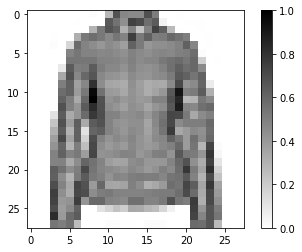

In [ ]:
#Show an image from test data, will show the first
for image, tag in training_data.take(1):
  break
image = image.numpy().reshape((28,28)) # Resize

import matplotlib.pyplot as plt

# Draw figure
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

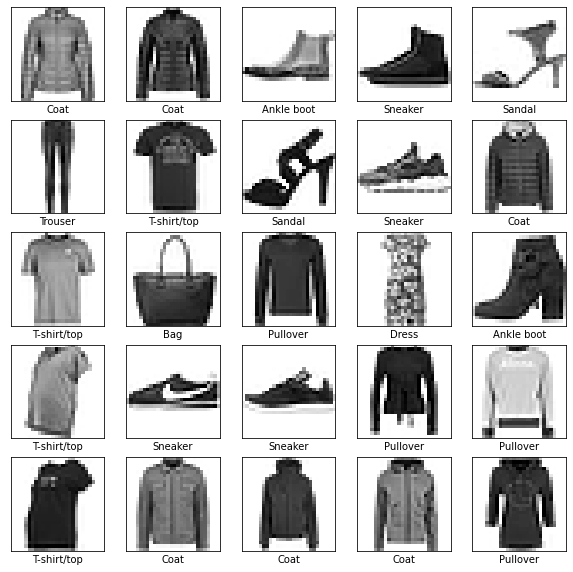

In [ ]:
plt.figure(figsize=(10,10))
for i, (image,tag) in enumerate(training_data.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(classes_names[tag])
plt.show()

In [ ]:
# Create model

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)),# Size:28x28 | 1 (Black&White)
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) # For network classification
])

In [ ]:
# Compile model

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
training_ex_num = metadata.splits["train"].num_examples
test_ex_num = metadata.splits["test"].num_examples

In [ ]:
print(training_ex_num)
print(test_ex_num)

60000
10000


In [ ]:
BATCH_SIZE = 32

training_data = training_data.repeat().shuffle(training_ex_num).batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)


In [ ]:
import math

# Train
record = model.fit(training_data, epochs=5, steps_per_epoch=math.ceil(training_ex_num/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5150 - accuracy: 0.8171
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3411 - accuracy: 0.8765
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2772 - accuracy: 0.8976
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2275 - accuracy: 0.9167
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1916 - accuracy: 0.9310


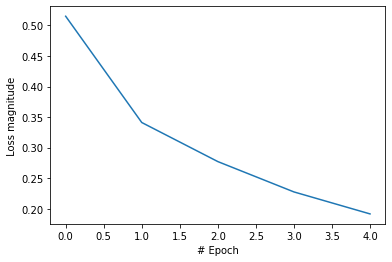

In [ ]:
plt.xlabel('# Epoch')
plt.ylabel(' Loss magnitude ')
plt.plot(record.history["loss"])

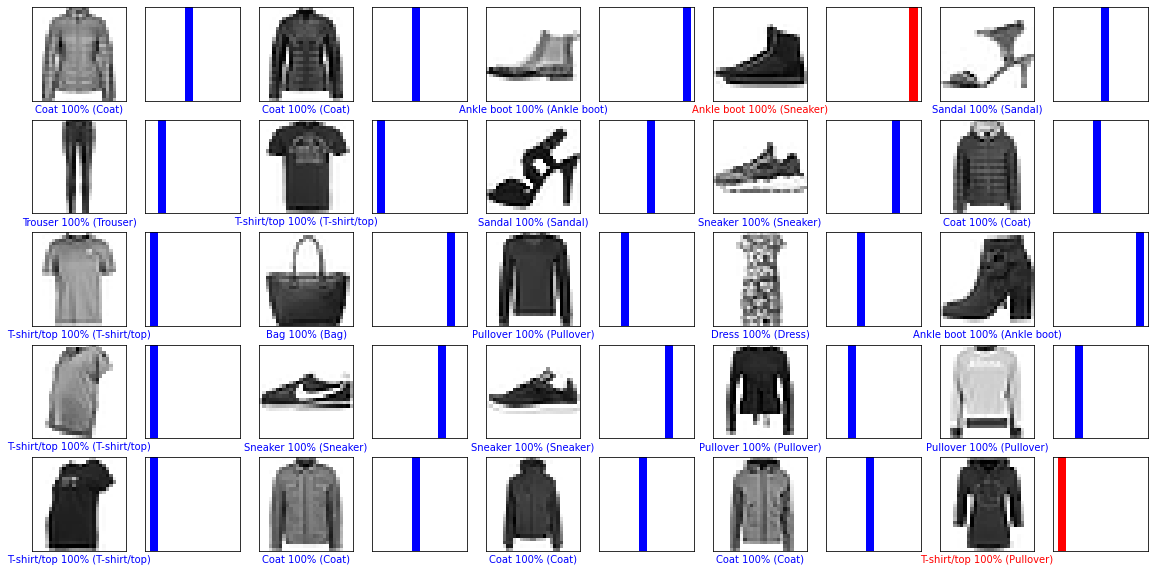

In [26]:
# Draw a Grid with predictions, mark if it's correct (blue) or incorrect (red)
import numpy as np

for test_images, test_tags in test_data.take(1):
  test_images = test_images.numpy()
  test_tags = test_tags.numpy()
  predictions = model.predict(test_images)

def image_graph(i, arr_predictions, real_tags, images):
  arr_predictions, real_tag, img = arr_predictions[i], real_tags[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  prediction_tag = np.argmax(arr_predictions)

  if prediction_tag == real_tag:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(classes_names[prediction_tag],
                                       100*np.max(arr_predictions),
                                       classes_names[real_tag]),
                                       color=color)

def array_value_graph(i, arr_predictions, real_tag):
  arr_predictions, real_tag = arr_predictions[i], real_tag[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  graph = plt.bar(range(10), arr_predictions, color="#777777")
  plt.ylim([0, 1])
  prediction_tag = np.argmax(arr_predictions)

  graph[prediction_tag].set_color('red')
  graph[real_tag].set_color('blue')

rows = 5
columns = 5
images_num = rows*columns
plt.figure(figsize=(2*2*columns, 2*rows))

for i in range(images_num):
  plt.subplot(rows, 2*columns, 2*i+1)
  image_graph(i, predictions, test_tags, test_images)
  plt.subplot(row, 2*columns, 2*i+2)
  array_value_graph(i, predictions, test_tags)


 Prediction: Sneaker


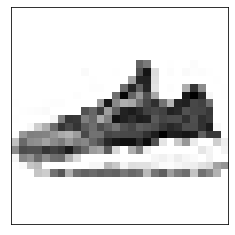

In [42]:
# Test a random image
select = 8
def print_image(i,images):
  img = images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[...,0], cmap=plt.cm.binary)


imagen = test_images[select]
imagen = np.array([imagen])
prediction = model.predict(imagen)

print_image(select,test_images)
print("\n Prediction: " + classes_names[np.argmax(prediction[0])])